<a href="https://colab.research.google.com/github/axiom-of-choice/DrivenDataCompetitions/blob/master/Notebook_for_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook contains my notebook for the Box-Plots for Education competition

The data can be found here : https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/

In [30]:
#import pandas as pd
#path = "../../datasets/"
#train = pd.read_csv(path + "TrainingData.csv")
#test = pd.read_csv(path + "TestData.csv")
#format = pd.read_csv(path + "SubmissionFormat.csv")
#df = train

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os 
os.getcwd()

'/content/drive/My Drive/datasets'

In [21]:
os.chdir('/content/drive/My Drive/datasets')

In [22]:
import pandas as pd 
train = pd.read_csv("TrainingData.csv")
test = pd.read_csv("TestData.csv")
format = pd.read_csv("SubmissionFormat.csv")
df = train

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Exploratory Data Analysis

In [23]:
display(train.info())
display(train.head())
display(train.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              400277 non-null  int64  
 1   Function                400277 non-null  object 
 2   Use                     400277 non-null  object 
 3   Sharing                 400277 non-null  object 
 4   Reporting               400277 non-null  object 
 5   Student_Type            400277 non-null  object 
 6   Position_Type           400277 non-null  object 
 7   Object_Type             400277 non-null  object 
 8   Pre_K                   400277 non-null  object 
 9   Operating_Status        400277 non-null  object 
 10  Object_Description      375493 non-null  object 
 11  Text_2                  88217 non-null   object 
 12  SubFund_Description     306855 non-null  object 
 13  Job_Title_Description   292743 non-null  object 
 14  Text_3              

None

,Unnamed: 0,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
0,134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
1,206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
2,326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
3,364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
4,47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


,Unnamed: 0,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
400272,109283,Professional Development,ISPD,Shared Services,Non-School,Unspecified,Instructional Coach,Other Compensation/Stipend,NO_LABEL,PreK-12 Operating,WORKSHOP PARTICIPANT,NaN,NaN,CURRICULUM RESOURCE TEACHER,NaN,NaN,NaN,STAFF DEV AND INSTR MEDIA,NaN,INST STAFF TRAINING SVCS,NaN,NaN,48.620000,NaN,GENERAL FUND,STAFF DEV AND INSTR MEDIA
400273,102430,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF PART TIME EMPLOYEE,NaN,FEDERAL GDPG FUND - FY,"Teacher,Retrd Shrt Term Sub",Regular,NaN,NaN,NaN,0.00431,"TITLE II,D",NaN,PROFESSIONAL-INSTRUCTIONAL,128.824985,INSTRUCTIONAL STAFF TRAINING,NaN,INSTRUCTIONAL STAFF
400274,413949,Parent & Community Relations,NO_LABEL,School Reported,School,NO_LABEL,Other,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,School Liaison,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,PARENT/TITLE I,4902.290000,Misc,Schoolwide Schools,NaN
400275,433672,Library & Media,Instruction,School on Central Budgets,Non-School,Unspecified,Librarian,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,EDUCATIONAL RESOURCE SERVICES,LEVY OVERRIDE,Library Technician II,NaN,NaN,NaN,ED RESOURCE SERVICES,NaN,NON-PROJECT,NaN,OFFICE/ADMINISTRATIVE SUPPORT,4020.290000,MEDIA SUPPORT SERVICES,NaN,INSTRUCTIONAL STAFF
400276,415831,Substitute Compensation,Instruction,School Reported,School,Poverty,Substitute,Substitute Compensation,Non PreK,PreK-12 Operating,Salaries And Wages For Substitute Professionals,NaN,"""Title Part A Improving Basic Programs""",TEACHER SUBSTITUTE POOL,NaN,Multilingual Dist Prof Development,Inservice Substitute Teachers Grant Funded,School,NaN,Instruction,Instruction And Curriculum,CERTIFIED SUBSTITUTE,46.530000,Accelerated Education,"""Title Part A Improving Basic Programs""",MISCELLANEOUS


Some of the column names correspond to features - descriptions of the budget items - such as the Job_Title_Description column. The values in this column tell us if a budget item is for a teacher, custodian, or other employee. Some columns correspond to the budget item labels you will be trying to predict with your model. For example, the Object_Type column describes whether the budget item is related classroom supplies, salary, travel expenses, etc.

FTE: Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee. Total: Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

In [24]:
for i in range(len(df)):
    if df.loc[i,'FTE'] > 2 :
        df.loc[i,'FTE'] = df['FTE'].median()
    else:
        pass

          Unnamed: 0            FTE         Total
count  400277.000000  126071.000000  3.957220e+05
mean   225186.018537       0.420513  1.310586e+04
std    130025.142718       0.452173  3.682254e+05
min         2.000000      -0.087551 -8.746631e+07
25%    112601.000000       0.000792  7.379770e+01
50%    225243.000000       0.130927  4.612300e+02
75%    337722.000000       1.000000  3.652662e+03
max    450340.000000       2.000000  1.297000e+08


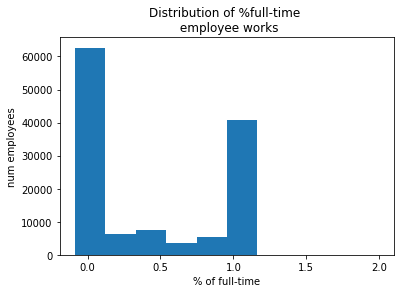

In [25]:
# Print the summary statistics
print(df.describe())
# Import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# Create the histogram
plt.hist(df['FTE'].dropna())
# Add title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
# Display the histogram
plt.show()

The high variance in expenditures makes sense (some purchases are cheap some are expensive). Also, it looks like the FTE column is bimodal. That is, there are some part-time and some full-time employees.

There are 9 columns of labels in the dataset. Each of these columns is a category that has many possible values it can take.

In [26]:
LABELS = ['Function','Use','Sharing','Reporting','Student_Type','Position_Type','Object_Type','Pre_K','Operating_Status']
# Define the lambda function: categorize_label
categorize_label = lambda x:x.astype('category')
# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label,axis=0)
# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


Observe there are over 100 unique labels

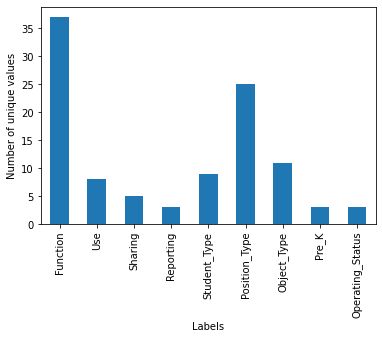

In [27]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = df[LABELS].apply(pd.Series.nunique)
# Plot number of unique values for each label
num_unique_labels.plot(kind = 'bar')
# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
# Display the plot
plt.show()

We know that log loss metric penalizes highly confident wrong answers much more than any other type

# I'ts time to build a model.
 * Always a Good Approach to start with a very simple model
 * Gives a Sense of how challeging the problem is
 * We will start with a model on numeric data only
    * Want to go from raw data to predictions quickly
 * With Multiclass Logistic Regression
    * Trainin classifier on each label separately and use those to predict
 * Format predictions and save to a csv
 * Compute log loss metric

## Splitting the multiclass dataset won't work here
Some labels only appear in small fraction of the data
* If we split up our data randomly it may end up with labels in test set that never appear in training set
* Solution: *StratifiedShuffleSplit*
    * **Only works with a single target variable**
    * We have many target variables
    * We will provide a function: *multilabel_train_test_split()*

## Splitting the data

In [28]:
NUMERIC_COLUMNS = df.columns[df.dtypes == 'float' ]
from multilabel import multilabel_train_test_split
data_to_train = df[NUMERIC_COLUMNS].fillna(-1000)
labels_to_use = pd.get_dummies(df[LABELS])
X_train,X_test,y_train,y_test = multilabel_train_test_split(data_to_train,labels_to_use,size=0.2,seed=123)
print("X_train info:")
print(X_train.info())
print("\nX_test info:")
print(X_test.info())
print("\ny_train info:")
print(y_train.info())
print("\ny_test info:")
print(y_test.info())

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 0 to 400276
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     320222 non-null  float64
 1   Total   320222 non-null  float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 4 to 400274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     80055 non-null  float64
 1   Total   80055 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 0 to 400276
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 4 to 400274
Columns: 104 entries, Function_Aides Compensa

## Training the model

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train,y_train)
print("Accuracy: {}".format(clf.score(X_test,y_test)))

Accuracy: 0.0


**OneVsRestClassifier**
   * Treats each column of y independently
   * Fits a separate classifier for each of the columns